# Final Year Project Data Analysis

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import os

todos:
- checking for duplicates
- resize
- group/cluster datasets (e.g. by noise level)
- use simpler models (SVM) to predict

## Loading Data

In [8]:
def load_images_in_a_directory(directory_path):
    images = []
    print(os.listdir(directory_path))
    for filename in os.listdir(directory_path):
        if filename.endswith("png") or filename.endswith("jpg"):
            image_path = os.path.join(directory_path, filename)
            image = Image.open(image_path)
            images.append(image)
    
    return images

In [12]:
os.listdir("SIE_Dataset/Real_world_images")

['Blowing_sand', 'Floating_dust', 'Sandstorm', 'Strong_sandstorm']

In [13]:
# loading ground truth images
path = "SIE_Dataset/Synthetic_images/Ground_truth"
gt_images = load_images_in_a_directory(path)

# loading corrupted images
path = "SIE_Dataset/Synthetic_images/Sand_dust_images"
dust_images = load_images_in_a_directory(path)

['001.jpg', '002.jpg', '003.jpg', '004.jpg', '005.jpg', '006.jpg', '007.jpg', '008.jpg', '009.jpg', '010.jpg', '011.jpg', '012.jpg', '013.jpg', '014.jpg', '015.jpg', '016.jpg', '017.jpg', '018.jpg', '019.jpg', '020.jpg', '021.jpg', '022.jpg', '023.jpg', '024.jpg', '025.jpg', '026.jpg', '027.jpg', '028.jpg', '029.jpg', '030.jpg', '031.jpg', '032.jpg', '033.jpg', '034.jpg', '035.jpg', '036.jpg', '037.jpg', '038.jpg', '039.jpg', '040.jpg', '041.jpg', '042.jpg', '043.jpg', '044.jpg', '045.jpg', '046.jpg', '047.jpg', '048.jpg', '049.jpg', '050.jpg', '051.jpg', '052.jpg', '053.jpg', '054.jpg', '055.jpg', '056.jpg', '057.jpg', '058.jpg', '059.jpg', '060.jpg', '061.jpg', '062.jpg', '063.jpg', '064.jpg', '065.jpg', '066.jpg', '067.jpg', '068.jpg', '069.jpg', '070.jpg', '071.jpg', '072.jpg', '073.jpg', '074.jpg', '075.jpg', '076.jpg', '077.jpg', '078.jpg', '079.jpg', '080.jpg', '081.jpg', '082.jpg', '083.jpg', '084.jpg', '085.jpg', '086.jpg', '087.jpg', '088.jpg', '089.jpg', '090.jpg', '091.jpg'

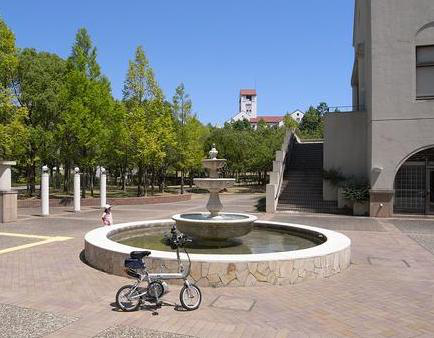

In [19]:
gt_images[0]

In [14]:
len(gt_images) == len(dust_images)

True

## Visualizing Images

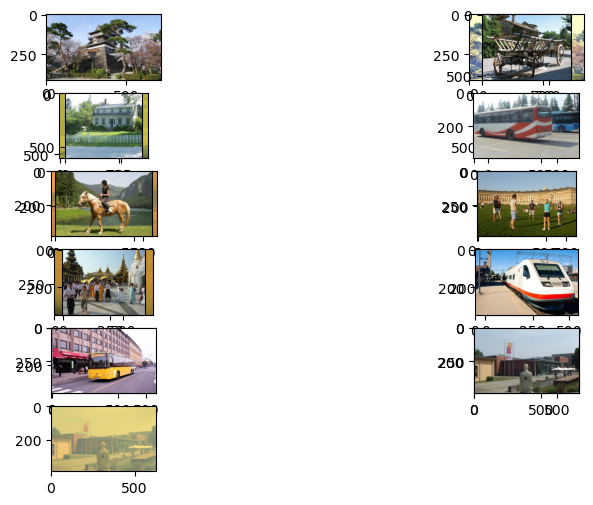

In [21]:
np.random.seed(123)
random_img_indices = np.random.randint(0, len(gt_images), size=(10, ))

fig = plt.figure(figsize=(10, 10))

for i in range(1, 11):
    ax1 = fig.add_subplot(10, 2, i)
    ax1.imshow(gt_images[random_img_indices[i-1]])
    ax2 = fig.add_subplot(10, 2, i+1)
    ax2.imshow(dust_images[random_img_indices[i-1]])